In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/flatiron-capstone-project/submission.csv
/kaggle/input/flatiron-capstone-project/train_df.csv
/kaggle/input/flatiron-capstone-project/preprocessed_df.csv
/kaggle/input/coleridgeinitiative-show-us-the-data/sample_submission.csv
/kaggle/input/coleridgeinitiative-show-us-the-data/train.csv
/kaggle/input/coleridgeinitiative-show-us-the-data/test/8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60.json
/kaggle/input/coleridgeinitiative-show-us-the-data/test/2100032a-7c33-4bff-97ef-690822c43466.json
/kaggle/input/coleridgeinitiative-show-us-the-data/test/2f392438-e215-4169-bebf-21ac4ff253e1.json
/kaggle/input/coleridgeinitiative-show-us-the-data/test/3f316b38-1a24-45a9-8d8c-4e05a42257c6.json
/kaggle/input/coleridgeinitiative-show-us-the-data/train/f8b03c87-9d1a-4f20-b76b-cb6c69d447b2.json
/kaggle/input/coleridgeinitiative-show-us-the-data/train/585ba241-6348-41ce-a5d2-c9ee434cd64d.json
/kaggle/input/coleridgeinitiative-show-us-the-data/train/bde73ad6-ce46-489b-8ee0-b162698cc6df.json
/kaggle/i

# Libraries

In [2]:
import pandas as pd
import numpy as np
import random
import time
import datetime

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS

import re
import json
from tqdm.autonotebook import tqdm
import string
import itertools

import nltk
from nltk.probability import FreqDist
from nltk.tokenize import word_tokenize

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, cross_val_score

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import classification_report, precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import confusion_matrix, plot_confusion_matrix

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

from keras.preprocessing import sequence, text
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import utils
from keras.models import *
from keras.layers import *
from keras.callbacks import *

from keras.models import Sequential
from keras.layers.recurrent import LSTM, GRU
from keras.layers import Dense, Dropout
from keras.layers.embeddings import Embedding
from keras.layers.normalization import BatchNormalization
from keras.utils.vis_utils import plot_model

import warnings
warnings.filterwarnings('ignore')



/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  


In [3]:
#define stopwords
from nltk.corpus import stopwords

stopwords_list = stopwords.words('english') + list(string.punctuation)
stopwords_list += ["''", '""', '...', '``']

In [4]:
#add callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint

#define the callbacks
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1),
                 ModelCheckpoint(filepath = 'cnn_model.h5', monitor = 'val_loss', save_best_only = True)]

# DEEP LEARNING: MLP, LSTM, GLOVE, and GRU

* Separate the data into training and test sets.
* Use tokenizer methods to count the unique words in our vocabulary and assign each of those words to indices.
* Calling fit_on_texts() automatically creates a word index lookup of our vocabulary.
* We limit our vocabulary to the top words by passing a num_words param to the tokenizer.
* With our tokenizer, we can now use the texts_to_sequence method to create the training data that we’ll pass our model.
* We feed a one-hot vector to our model.
* After we transform our features and labels in a format Keras can read, we are ready to build our text classification model.
* When we build our model, all we need to do is tell Keras the shape of our input data, output data, and the type of each layer, keras will look after the rest.
* When training the model, we’ll call the fit() method, pass it our training data and labels, batch size and epochs.

# OBTAIN

In [5]:
#read train data
train_df = pd.read_csv('../input/flatiron-capstone-project/train_df.csv', index_col = 0)
train_df.head()

Id  \
0  d0fa7568-7d8e-4db9-870f-f9c6f668c17b   
1  2f26f645-3dec-485d-b68d-f013c9e05e60   
2  c5d5cd2c-59de-4f29-bbb1-6a88c7b52f29   
3  5c9a3bc9-41ba-4574-ad71-e25c1442c8af   
4  c754dec7-c5a3-4337-9892-c02158475064   

                                           pub_title  \
0  The Impact of Dual Enrollment on College Degre...   
1  Educational Attainment of High School Dropouts...   
2  Differences in Outcomes for Female and Male St...   
3  Stepping Stone and Option Value in a Model of ...   
4  Parental Effort, School Resources, and Student...   

                           dataset_title  \
0  National Education Longitudinal Study   
1  National Education Longitudinal Study   
2  National Education Longitudinal Study   
3  National Education Longitudinal Study   
4  National Education Longitudinal Study   

                           dataset_label  \
0  National Education Longitudinal Study   
1  National Education Longitudinal Study   
2  National Education Longitudinal Study   
3  National Education Longitudinal Study   
4  National Education Longitudinal Study   

                           cleaned_label  \
0  national education longitudinal study   
1  national education longitudinal study   
2  national education longitudinal study   
3  national education longitudinal study   
4  national education longitudinal study   

                                                text  
0  this study used data from the national educati...  
1  dropping out of high school is not necessarily...  
2  stress satisfactory outcomes for all youth inc...  
3  federal reserve bank of richmond s1 accounting...  
4  this article investigates an important factor ...

In [6]:
#read submission data
submission_df = pd.read_csv('../input/flatiron-capstone-project/submission.csv', index_col = 0)
submission_df.head()

Id  PredictionString  \
0  2100032a-7c33-4bff-97ef-690822c43466               NaN   
1  2f392438-e215-4169-bebf-21ac4ff253e1               NaN   
2  3f316b38-1a24-45a9-8d8c-4e05a42257c6               NaN   
3  8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60               NaN   

                                                text  
0  Cognitive deficits and reduced educational ach...  
1  This report describes how the education system...  
2  Cape Hatteras National Seashore (CAHA), locate...  
3  A significant body of research has been conduc...

Now, our job is to fill in the column 'PredictionString' with cleaned_label that matches the given text.

# PREPROCESSING

### Train-Test-Split

In [7]:
X = train_df['dataset_title'].to_numpy()
y = train_df['cleaned_label'].to_numpy()

#split traing data into training a validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 123)

In [8]:
#check shape
print('Train sentences:', X_train.shape, '\n', 
      'Test sentences:', X_test.shape, '\n', 
      'Train labels:', y_train.shape, '\n', 
      'Test labels:', y_test.shape)

Train sentences: (15728,) 
 Test sentences: (3933,) 
 Train labels: (15728,) 
 Test labels: (3933,)


In [9]:
# find avg # of takens (words) in the training set
round(sum([len(i.split()) for i in X_train]) / len(X_train))

5

### Vectorize Features

In [10]:
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 5 #max length our sequences will be 

import tensorflow as tf
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

text_vectorizer = TextVectorization(max_tokens = max_vocab_length,
                                    output_mode = 'int',
                                    output_sequence_length = max_length)

#fit the text vectorizer to dataset, .adapt method sets the layer's vocabulary
text_vectorizer.adapt(X_train)
text_vectorizer.adapt(X_test)

### Tokenize Features

In [11]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

#method to count the unique words in vocabulary and assign each of those words to indices
tokenizer = Tokenizer()

#prepare vocabulary i.e word index lookup of our vocabulary
tokenizer.fit_on_texts(list(X_train) + list(X_test)) 

#convert text into integer sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

#padding to prepare sequences of same length
X_train_pad  = pad_sequences(X_train_seq, maxlen = 100)
X_test_pad = pad_sequences(X_test_seq, maxlen = 100)

In [12]:
#number of unique words in the training data
size_of_vocabulary = len(tokenizer.word_index) + 1 #+1 for padding
print(size_of_vocabulary)

154


In [13]:
word_index = tokenizer.word_index
word_index

{'disease': 1,
 "alzheimer's": 2,
 'neuroimaging': 3,
 'initiative': 4,
 'adni': 5,
 'study': 6,
 'of': 7,
 'longitudinal': 8,
 'survey': 9,
 'and': 10,
 'international': 11,
 'aging': 12,
 'baltimore': 13,
 'blsa': 14,
 'in': 15,
 'education': 16,
 'science': 17,
 'trends': 18,
 'mathematics': 19,
 'early': 20,
 'childhood': 21,
 'sars': 22,
 'cov': 23,
 '2': 24,
 'genome': 25,
 'sequence': 26,
 'national': 27,
 'census': 28,
 'agriculture': 29,
 'data': 30,
 '19': 31,
 'agricultural': 32,
 'resource': 33,
 'management': 34,
 'sea': 35,
 'north': 36,
 'american': 37,
 'breeding': 38,
 'bird': 39,
 'bbs': 40,
 'world': 41,
 'earned': 42,
 'doctorates': 43,
 'rural': 44,
 'urban': 45,
 'continuum': 46,
 'codes': 47,
 'covid': 48,
 'beginning': 49,
 'postsecondary': 50,
 'student': 51,
 'for': 52,
 'noaa': 53,
 'tide': 54,
 'gauge': 55,
 'dataset': 56,
 'program': 57,
 'best': 58,
 'track': 59,
 'archive': 60,
 'climate': 61,
 'stewardship': 62,
 'common': 63,
 'core': 64,
 'research': 6

### Encode Label

In [14]:
from sklearn import preprocessing

#use the LabelEncoder to convert text labels to integers, 0, 1, 2, etc.
encoder = preprocessing.LabelEncoder()

#since we have two different data set (X_train and X_test), 
#we need to fit it on all of our data otherwise there might be some categories in the test set X_test that were not in the train set X_train 
#and we will get errors
encoder.fit(list(y_train) + list(y_test)) 
y_train = encoder.transform(y_train)
y_test = encoder.transform(y_test)

### Binarize Label

In [15]:
from keras import utils

#binarize the labels for the neural net
num_classes = np.max(y_train) + 1
y_train = utils.to_categorical(y_train, num_classes)
y_test = utils.to_categorical(y_test, num_classes)

In [16]:
print('X_train shape:', X_train_pad.shape)
print('X_test shape:', X_test_pad.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

X_train shape: (15728, 100)
X_test shape: (3933, 100)
y_train shape: (15728, 130)
y_test shape: (3933, 130)


# Multilayer Perceptron

In [17]:
#deep learning library
from tensorflow import keras
from keras.models import *
from keras.layers import *
from keras.callbacks import *

In [18]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

batch_size = 32
epochs = 30

#build the model
MLP_model = Sequential()

MLP_model.add(Dense(512, activation = 'relu', input_shape = (15728, 100)))
MLP_model.add(Dropout(0.2))
          
MLP_model.add(Dense(128, activation = 'relu'))
MLP_model.add(Dropout(0.3))
          
MLP_model.add(Dense(num_classes, activation = 'softmax'))

In [19]:
#get summary
MLP_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 15728, 512)        51712     
_________________________________________________________________
dropout (Dropout)            (None, 15728, 512)        0         
_________________________________________________________________
dense_1 (Dense)              (None, 15728, 128)        65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 15728, 128)        0         
_________________________________________________________________
dense_2 (Dense)              (None, 15728, 130)        16770     
Total params: 134,146
Trainable params: 134,146
Non-trainable params: 0
_________________________________________________________________


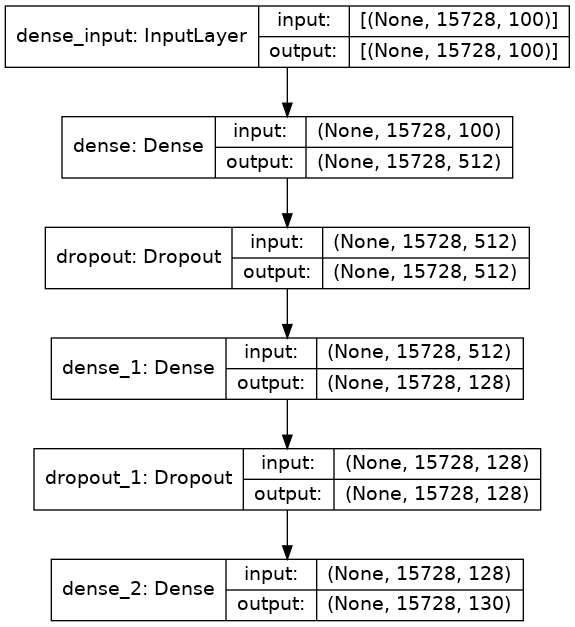

In [20]:
#plot
from keras.utils.vis_utils import plot_model

plot_model(MLP_model, to_file = 'mlp_model_plot.png', show_shapes = True, show_layer_names = True)

In [24]:
#compile model
MLP_model.compile(loss = 'categorical_crossentropy',
                  optimizer = keras.optimizers.Adam(0.0001),
                  metrics = ['acc'])

In [25]:
#add callbacks
from keras.callbacks import EarlyStopping, ModelCheckpoint

#define the callbacks
early_stopping = [EarlyStopping(monitor = 'val_loss', patience = 5, verbose = 1),
                 ModelCheckpoint(filepath = 'best_model.h5', monitor = 'val_loss', save_best_only = True)]

Cross-validation in Deep Learning (DL) might be a little tricky because most of the CV techniques require training the model at least a couple of times. 

In deep learning, we would normally tempt to avoid CV because of the cost associated with training k different models. Instead of doing k-Fold or other CV technique, we use a random subset of our training data as a hold-out for validation purposes. i.e validation_data

In [26]:
import datetime
start = datetime.datetime.now()

#fit
MLP_history = MLP_model.fit(np.array(X_train_pad), np.array(y_train),
                         batch_size = 32,
                         epochs = 30,
                         validation_data = (np.array(X_test_pad), np.array(y_test)),
                         verbose = 1,
                         callbacks = early_stopping)

Epoch 1/30
492/492 [==============================] - 2s 3ms/step - loss: 5.5225 - acc: 0.1134 - val_loss: 2.7350 - val_acc: 0.6074
Epoch 2/30
492/492 [==============================] - 1s 3ms/step - loss: 3.0257 - acc: 0.5166 - val_loss: 1.6628 - val_acc: 0.6829
Epoch 3/30
492/492 [==============================] - 1s 3ms/step - loss: 1.9163 - acc: 0.6013 - val_loss: 1.0478 - val_acc: 0.7048
Epoch 4/30
492/492 [==============================] - 1s 3ms/step - loss: 1.3599 - acc: 0.6378 - val_loss: 0.8529 - val_acc: 0.7203
Epoch 5/30
492/492 [==============================] - 2s 3ms/step - loss: 1.1507 - acc: 0.6451 - val_loss: 0.7955 - val_acc: 0.7279
Epoch 6/30
492/492 [==============================] - 1s 3ms/step - loss: 1.0397 - acc: 0.6662 - val_loss: 0.7434 - val_acc: 0.7330
Epoch 7/30
492/492 [==============================] - 1s 3ms/step - loss: 0.9583 - acc: 0.6767 - val_loss: 0.7214 - val_acc: 0.7340
Epoch 8/30
492/492 [==============================] - 1s 3ms/step - loss: 0.

In [27]:
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Training took a total of 0:01:34.502112


In [28]:
#save model
MLP_model.save('mlp_model.h5')

### Model Evaluation

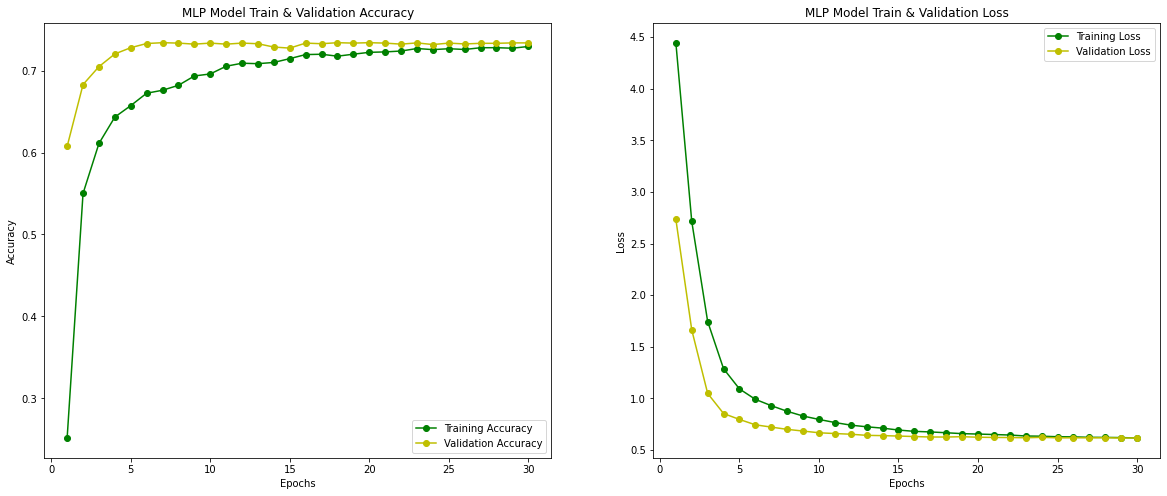

<Figure size 432x288 with 0 Axes>

In [29]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 8)

MLP_train_acc = MLP_history.history['acc']
MLP_train_loss = MLP_history.history['loss']
MLP_val_acc = MLP_history.history['val_acc']
MLP_val_loss = MLP_history.history['val_loss']

epochs = range(1, len(MLP_train_acc) + 1)

ax[0].plot(epochs , MLP_train_acc , 'g-o' , label = 'Training Accuracy')
ax[0].plot(epochs , MLP_val_acc , 'y-o' , label = 'Validation Accuracy')
ax[0].set_title('MLP Model Train & Validation Accuracy')
ax[0].legend(loc = 'lower right')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs , MLP_train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , MLP_val_loss , 'y-o' , label = 'Validation Loss')
ax[1].set_title('MLP Model Train & Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

plt.show()

#save
plt.savefig('mlp_acc_loss.png')

In [30]:
#evaluate
print('Train loss & accuracy:', MLP_model.evaluate(X_train_pad, y_train))
print('\n')
print('Test loss & accuracy:', MLP_model.evaluate(X_test_pad, y_test))

492/492 [==============================] - 1s 2ms/step - loss: 0.5885 - acc: 0.7334
Train loss & accuracy: [0.5885469913482666, 0.7334054112434387]


123/123 [==============================] - 0s 2ms/step - loss: 0.6166 - acc: 0.7338
Test loss & accuracy: [0.6166464686393738, 0.7337909936904907]


In [32]:
#make prediction
MLP_yhat_test = MLP_model.predict(X_test_pad)

#to evaluate accuracy we need a vector of labels
MLP_yhat_test = np.argmax(MLP_yhat_test, axis = 1)
MLP_y_test = np.argmax(y_test, axis = 1)

#get classification report
print('Model: Multilayer Perceptron', '\n', classification_report(MLP_y_test, MLP_yhat_test))

Model: Multilayer Perceptron 
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         2
           3       0.58      1.00      0.74       709
           4       0.00      0.00      0.00         2
           8       0.94      1.00      0.97       127
           9       0.00      0.00      0.00         8
          10       0.00      0.00      0.00       487
          11       0.00      0.00      0.00        17
          12       0.40      1.00      0.57         2
          13       0.00      0.00      0.00         1
          15       0.68      1.00      0.81        45
          16       0.00      0.00      0.00        21
          17       0.74      1.00      0.85       248
          18       0.00      0.00      0.00        86
          19       0.00      0.00      0.00        13
          20       0.00      0.00      0.00        47
          21       0.00      0.00      0.00       

In [ ]:
#from the sklearn docs: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools

def plot_confusion_matrix(cm, classes,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    
    #compute confusion matrix
    cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]
    
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title, fontsize = 30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90, fontsize = 12)
    plt.yticks(tick_marks, classes, fontsize = 12)

    #loop over data dimensions and create text annotations
    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.ylabel('True label', fontsize = 25)
    plt.xlabel('Predicted label', fontsize = 25)
    plt.tight_layout()

In [ ]:
#code from https://github.com/tensorflow/workshops/blob/master/extras/keras-bag-of-words/keras-bow-model.ipynb

#generate a prediction on individual examples
MLP_text_labels = encoder.classes_ 

for i in range(10):
    prediction = MLP_model.predict(np.array([X_test_pad[i]]))
    predicted_label = MLP_text_labels[np.argmax(prediction)]
    print(train_df['dataset_title'].iloc[i][:50], '...')
    print('Actual label: ' + train_df['cleaned_label'].iloc[i])
    print('Predicted label: ' + predicted_label + '\n')

In [ ]:
y_softmax = MLP_model.predict(X_test_pad)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

In [ ]:
#get confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize = (40, 40))
plot_confusion_matrix(cm, classes = MLP_text_labels, title = 'MLP Confusion Matrix')
plt.show()

#save
plt.savefig('mlp_cm.png')

In [ ]:
#heatmap of cm
plt.figure(figsize = (30, 30))
sns.heatmap(cm, annot = True, fmt = '', cmap = 'Blues')

In [ ]:
#summary table
summary_table = pd.DataFrame({'Model': [],
                              'Accuracy': [],
                              'Precision': [], 'Recall': [], 'F1': []})

In [ ]:
#update summary table
summary_table.loc[0] = ['DL MLP',
                        round(accuracy_score(MLP_y_test, MLP_yhat_test), 2),
                        round(precision_score(MLP_y_test, MLP_yhat_test, average = 'macro'), 2), 
                        round(recall_score(MLP_y_test, MLP_yhat_test, average = 'macro'), 2), 
                        round(f1_score(MLP_y_test, MLP_yhat_test, average = 'macro'), 2)]
summary_table.head()

# LSTM

In [36]:
#instantiate
LSTM_model = Sequential()

#embedding layer
LSTM_model.add(Embedding(size_of_vocabulary, 300, 
                         input_length = 100)) 

#lstm layer
LSTM_model.add(LSTM(128, return_sequences = True, dropout = 0.2))

#global mxpooling
LSTM_model.add(GlobalMaxPooling1D())

#fully connected layers
LSTM_model.add(Dense(64, activation = 'relu')) 
LSTM_model.add(Dense(130, activation = 'sigmoid')) 

In [37]:
#summary
LSTM_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          46200     
_________________________________________________________________
lstm (LSTM)                  (None, 100, 128)          219648    
_________________________________________________________________
global_max_pooling1d (Global (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 130)               8450      
Total params: 282,554
Trainable params: 282,554
Non-trainable params: 0
_________________________________________________________________


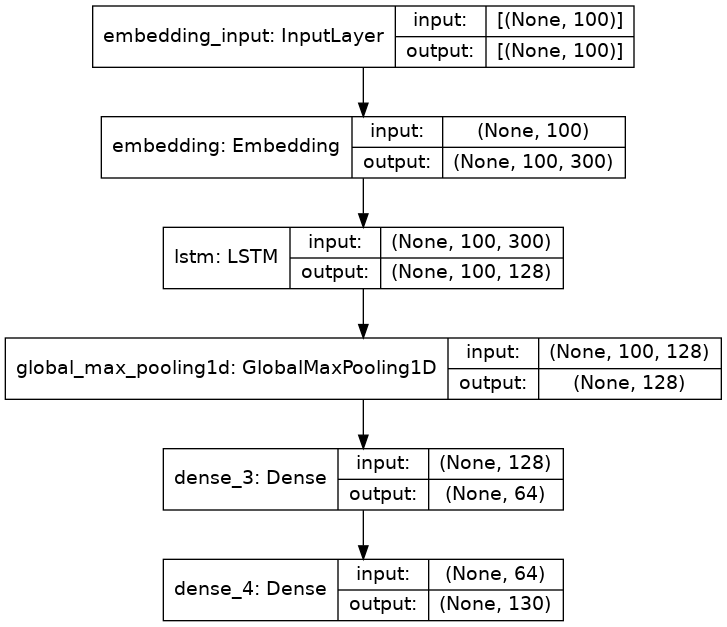

In [38]:
#plot
plot_model(LSTM_model, to_file = 'LSTM_model_plot.png', show_shapes = True, show_layer_names = True)

In [39]:
#add loss function, metrics, optimizer
LSTM_model.compile(optimizer = keras.optimizers.Adam(0.0001), 
                   loss = 'categorical_crossentropy', 
                   metrics = ['acc']) 

In [40]:
import datetime
start = datetime.datetime.now()

#fit
LSTM_history = LSTM_model.fit(np.array(X_train_pad), np.array(y_train),
                         batch_size = 32,
                         epochs = 30,
                         validation_data = (np.array(X_test_pad), np.array(y_test)),
                         verbose = 1,
                         callbacks = early_stopping)

Epoch 1/30
492/492 [==============================] - 11s 15ms/step - loss: 0.1364 - acc: 0.1745 - val_loss: 0.0339 - val_acc: 0.1803
Epoch 2/30
492/492 [==============================] - 7s 13ms/step - loss: 0.0335 - acc: 0.1874 - val_loss: 0.0325 - val_acc: 0.1803
Epoch 3/30
492/492 [==============================] - 7s 13ms/step - loss: 0.0316 - acc: 0.1919 - val_loss: 0.0298 - val_acc: 0.2433
Epoch 4/30
492/492 [==============================] - 6s 13ms/step - loss: 0.0292 - acc: 0.2363 - val_loss: 0.0285 - val_acc: 0.2433
Epoch 5/30
492/492 [==============================] - 7s 15ms/step - loss: 0.0282 - acc: 0.2435 - val_loss: 0.0279 - val_acc: 0.1869
Epoch 6/30
492/492 [==============================] - 6s 13ms/step - loss: 0.0269 - acc: 0.2725 - val_loss: 0.0222 - val_acc: 0.4701
Epoch 7/30
492/492 [==============================] - 6s 13ms/step - loss: 0.0184 - acc: 0.5487 - val_loss: 0.0109 - val_acc: 0.7091
Epoch 8/30
492/492 [==============================] - 6s 13ms/step -

In [41]:
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Training took a total of 0:03:22.161455


In [42]:
#save model
LSTM_model.save('lstm_model.h5')

### Model Evaluation

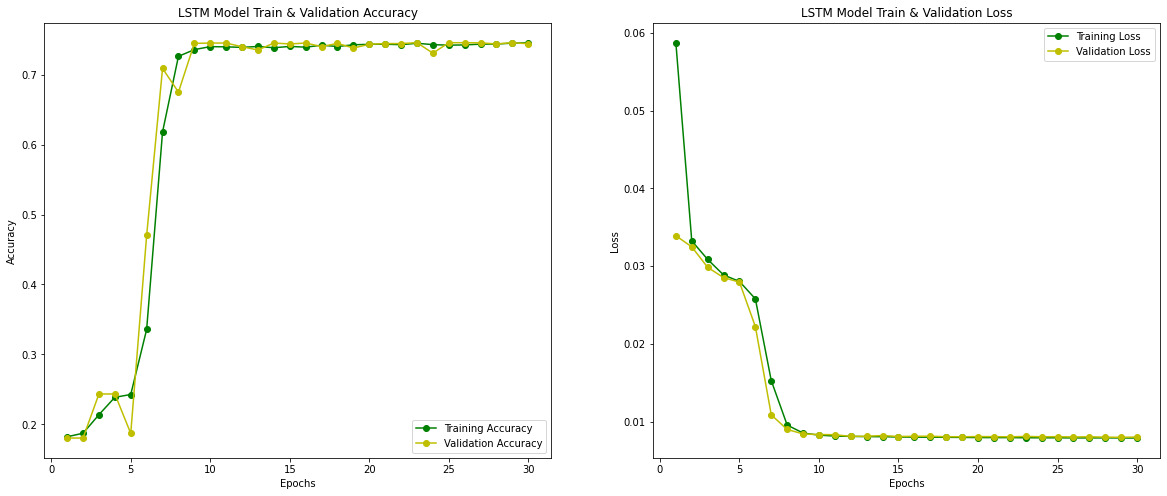

<Figure size 432x288 with 0 Axes>

In [43]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 8)

LSTM_train_acc = LSTM_history.history['acc']
LSTM_train_loss = LSTM_history.history['loss']
LSTM_val_acc = LSTM_history.history['val_acc']
LSTM_val_loss = LSTM_history.history['val_loss']

epochs = range(1, len(LSTM_train_acc) + 1)

ax[0].plot(epochs, LSTM_train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , LSTM_val_acc , 'yo-' , label = 'Validation Accuracy')
ax[0].set_title('LSTM Model Train & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, LSTM_train_loss , 'go-' , label = 'Training Loss')
ax[1].plot(epochs, LSTM_val_loss , 'yo-' , label = 'Validation Loss')
ax[1].set_title('LSTM Model Train & Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss')

plt.show()

#save
plt.savefig('lstm_acc_loss.png')

In [44]:
#evaluation 
print('Train loss & accuracy:', LSTM_model.evaluate(X_train_pad, y_train))
print('\n')
print('Test loss & accuracy:', LSTM_model.evaluate(X_test_pad, y_test))

492/492 [==============================] - 2s 5ms/step - loss: 0.0079 - acc: 0.7447
Train loss & accuracy: [0.007859823293983936, 0.7446591854095459]


123/123 [==============================] - 1s 5ms/step - loss: 0.0080 - acc: 0.7445
Test loss & accuracy: [0.008020876906812191, 0.7444698810577393]


In [45]:
#make prediction
LSTM_yhat_test = LSTM_model.predict(X_test_pad)

#to evaluate accuracy we need a vector of labels
LSTM_yhat_test = np.argmax(LSTM_yhat_test, axis = 1)
LSTM_y_test = np.argmax(y_test, axis = 1)

#get classification report
print('Model: LSTM', '\n', classification_report(LSTM_y_test, LSTM_yhat_test))

Model: LSTM 
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         2
           3       0.58      1.00      0.74       709
           4       0.00      0.00      0.00         2
           8       0.94      1.00      0.97       127
           9       0.00      0.00      0.00         8
          10       0.00      0.00      0.00       487
          11       0.00      0.00      0.00        17
          12       0.40      1.00      0.57         2
          13       0.00      0.00      0.00         1
          15       0.68      1.00      0.81        45
          16       0.00      0.00      0.00        21
          17       0.74      1.00      0.85       248
          18       0.00      0.00      0.00        86
          19       0.00      0.00      0.00        13
          20       0.47      1.00      0.64        47
          21       0.00      0.00      0.00        39
          25 

In [46]:
#generate a prediction on individual examples
LSTM_text_labels = encoder.classes_ 

for i in range(10):
    prediction = LSTM_model.predict(np.array([X_test_pad[i]]))
    predicted_label = LSTM_text_labels[np.argmax(prediction)]
    print(train_df['dataset_title'].iloc[i][:50], '...')
    print('Actual label: ' + train_df['cleaned_label'].iloc[i])
    print('Predicted label: ' + predicted_label + '\n')

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: baltimore longitudinal study of aging

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: adni

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: noaa tide gauge

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: trends in international mathematics and science study

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: our world in data

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: adni

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: adni

National Education Longitudinal Study ...
Actual label: national education 

In [47]:
y_softmax = LSTM_model.predict(X_test_pad)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

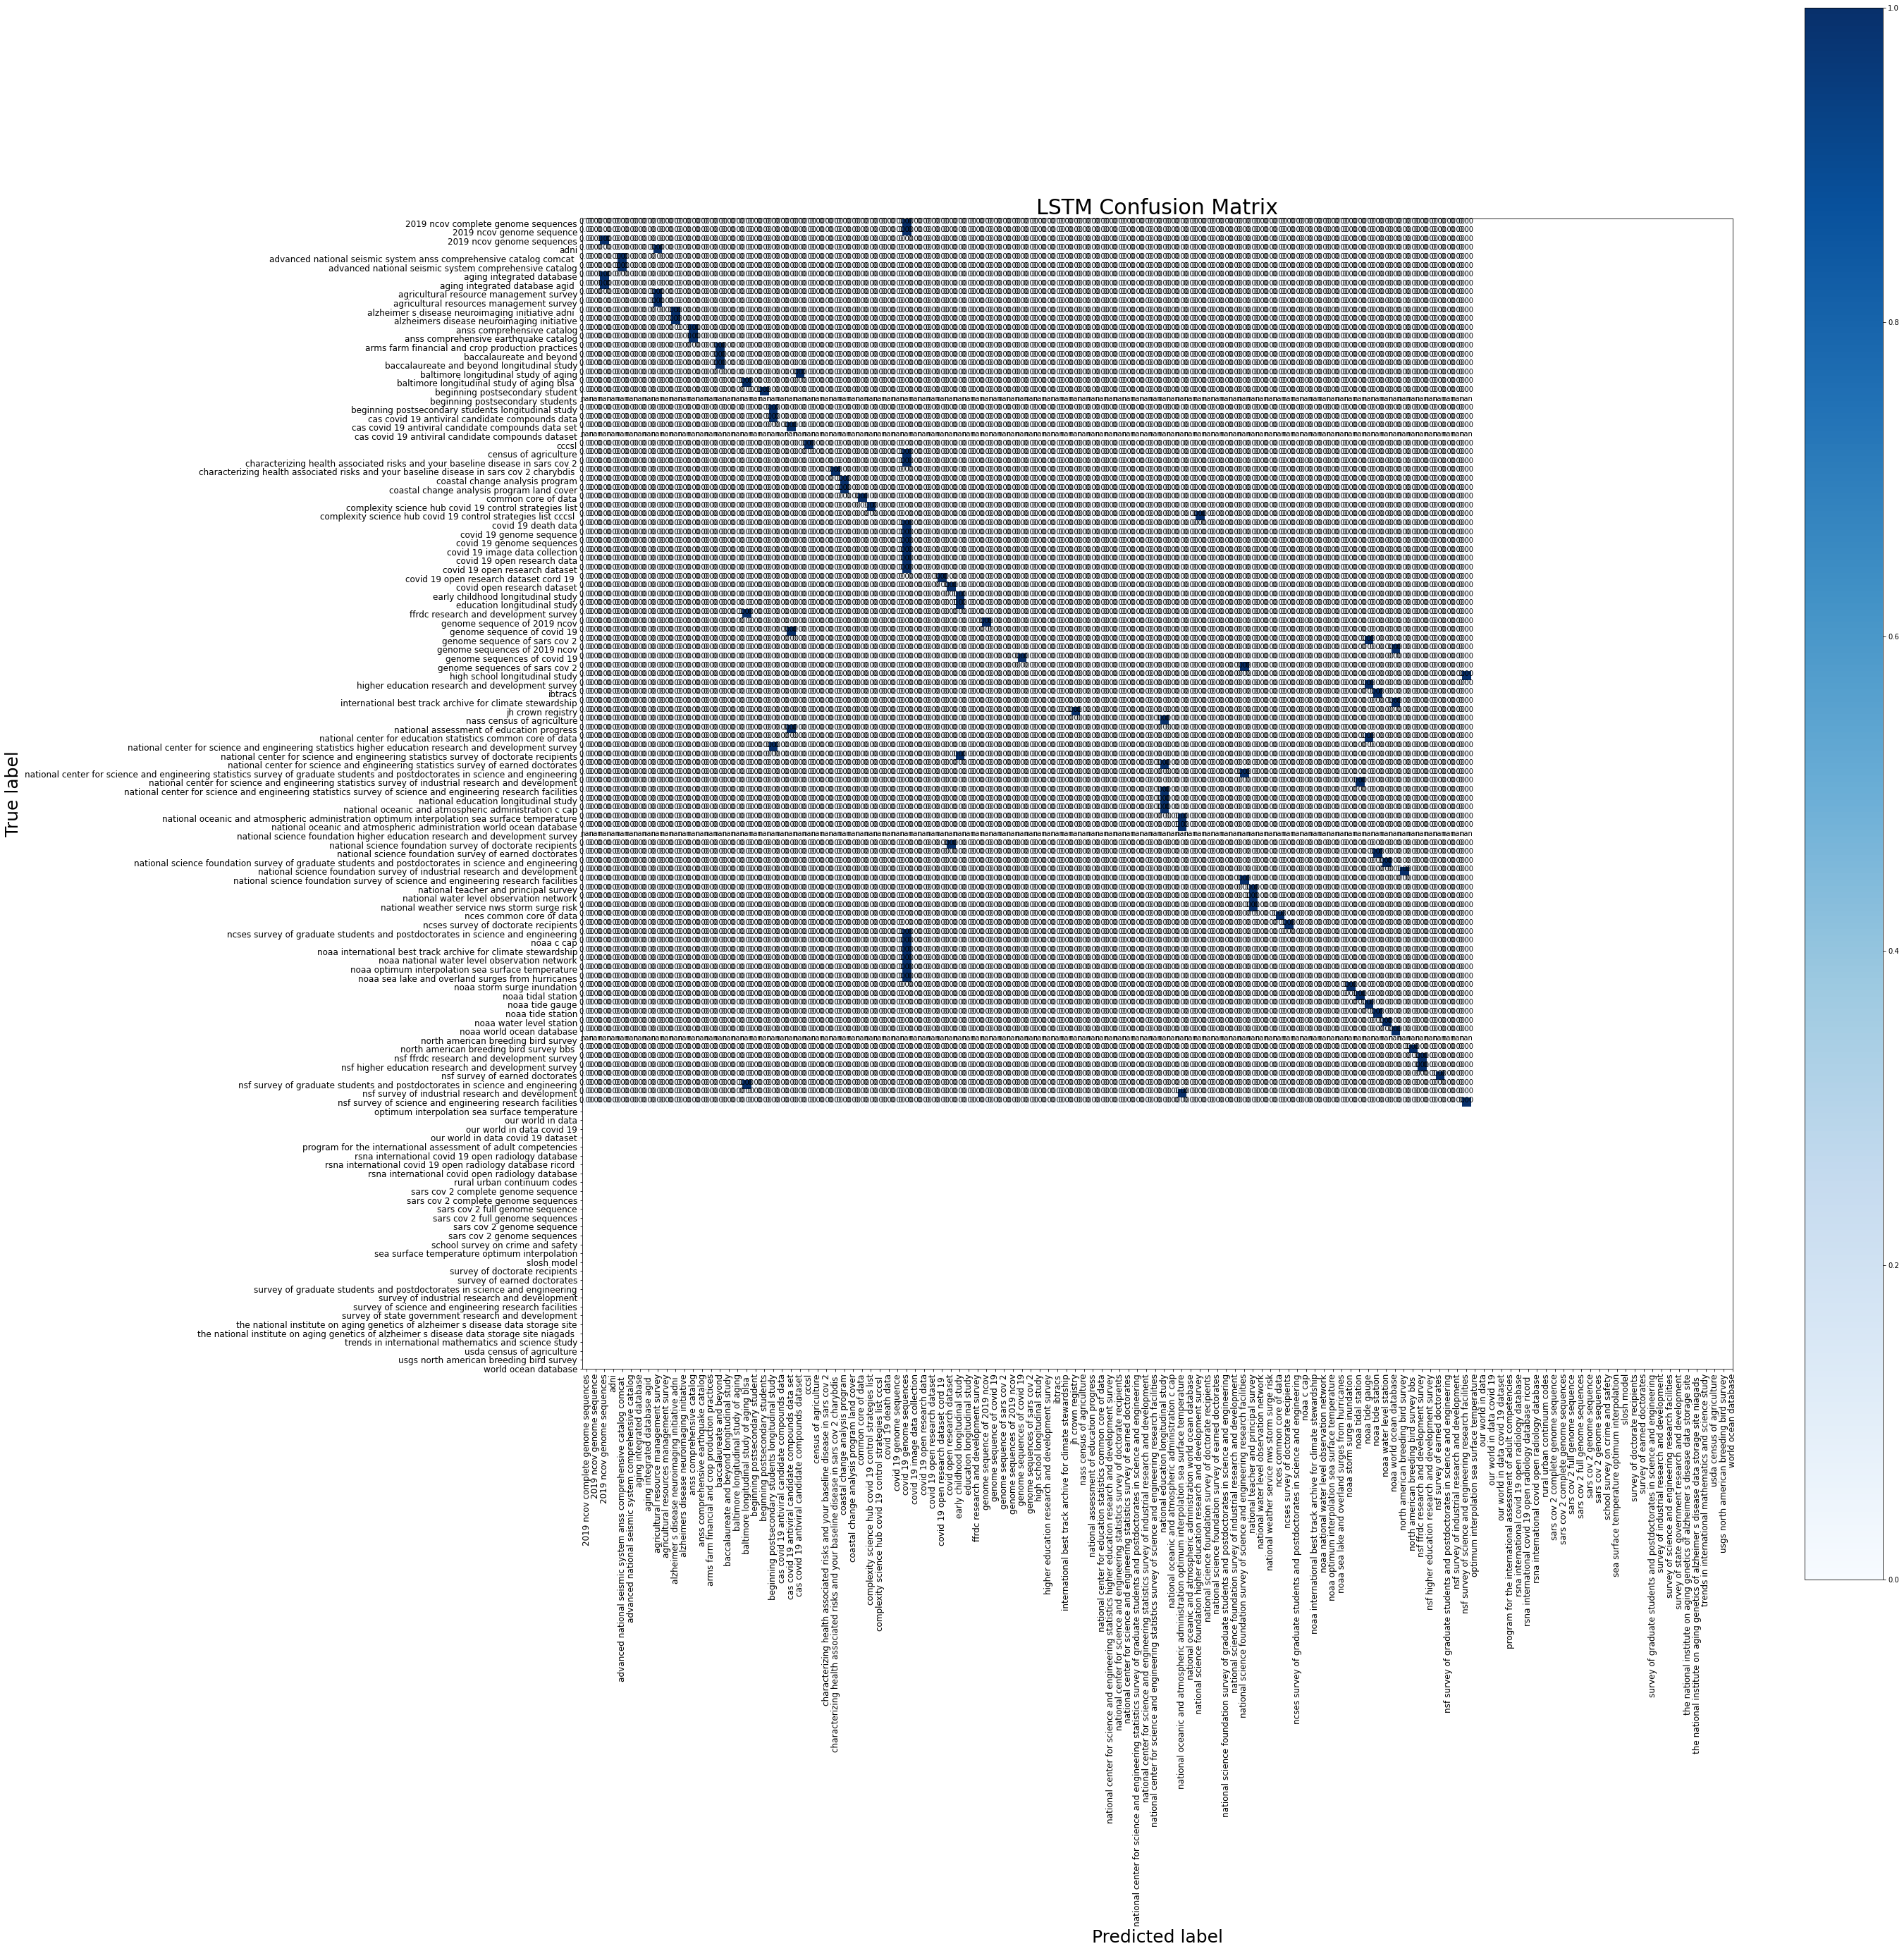

<Figure size 432x288 with 0 Axes>

In [48]:
#get confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize = (40, 40))
plot_confusion_matrix(cm, classes = LSTM_text_labels, title = 'LSTM Confusion Matrix')
plt.show()

#save
plt.savefig('lstm_cm.png')

In [49]:
summary_table.loc[1] = ['DL LSTM',
                        round(accuracy_score(LSTM_y_test, LSTM_yhat_test), 2),
                        round(precision_score(LSTM_y_test, LSTM_yhat_test, average = 'macro'), 2), 
                        round(recall_score(LSTM_y_test, LSTM_yhat_test, average = 'macro'), 2), 
                        round(f1_score(LSTM_y_test, LSTM_yhat_test, average = 'macro'), 2)]
summary_table.head()

Model  Accuracy  Precision  Recall    F1
0   DL MLP      0.73       0.32    0.37  0.34
1  DL LSTM      0.74       0.31    0.37  0.33

# Pretrained Word Vectors With GloVe

Global Vectors for Word Representation, or GloVe, is an “unsupervised learning algorithm for obtaining vector representations for words.” Simply put, GloVe allows us to take a corpus of text, and intuitively transform each word in that corpus into a position in a high-dimensional space. This means that similar words will be placed together.

In [50]:
#load the whole embedding into memory
embeddings_index = {}
f = open('../input/glove840b300dtxt/glove.840B.300d.txt')

for line in tqdm(f):
    values = line.split()
    word = values[0]
    try:
        coefs = np.asarray(values[1:], dtype = 'float32')
        embeddings_index[word] = coefs
    except ValueError: #catch the exception where there are strings in the GloVe text file, can be avoided if use glove.42B.300d.txt
        pass
    
f.close()

print('Found %s word vectors.' % len(embeddings_index))

0it [00:00, ?it/s]

Found 2195885 word vectors.


In [51]:
#create an embedding matrix for the words we have in the dataset
embedding_matrix = np.zeros((len(word_index) + 1, 300))
for word, i in tqdm(word_index.items()):
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

  0%|          | 0/153 [00:00<?, ?it/s]

In [53]:
#simple bidirectional LSTM with GloVe embeddings and two dense layers
GloVe_model = Sequential()

#embedding layer
GloVe_model.add(Embedding(size_of_vocabulary, 300, 
                          weights = [embedding_matrix], 
                          input_length = 100, 
                          trainable = False)) 

#lstm layer
GloVe_model.add(LSTM(128, return_sequences = True, dropout = 0.2))
GloVe_model.add(SpatialDropout1D(0.3))
GloVe_model.add(Bidirectional(LSTM(300, dropout = 0.3, recurrent_dropout = 0.3)))

#fully connected layers
GloVe_model.add(Dense(1024, activation = 'relu'))
GloVe_model.add(Dropout(0.8))

GloVe_model.add(Dense(512, activation = 'relu'))
GloVe_model.add(Dropout(0.5))

#output layer
GloVe_model.add(Dense(130, activation = 'sigmoid')) 

In [54]:
#summary
GloVe_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 300)          46200     
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 128)          219648    
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 100, 128)          0         
_________________________________________________________________
bidirectional (Bidirectional (None, 600)               1029600   
_________________________________________________________________
dense_5 (Dense)              (None, 1024)              615424    
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)              

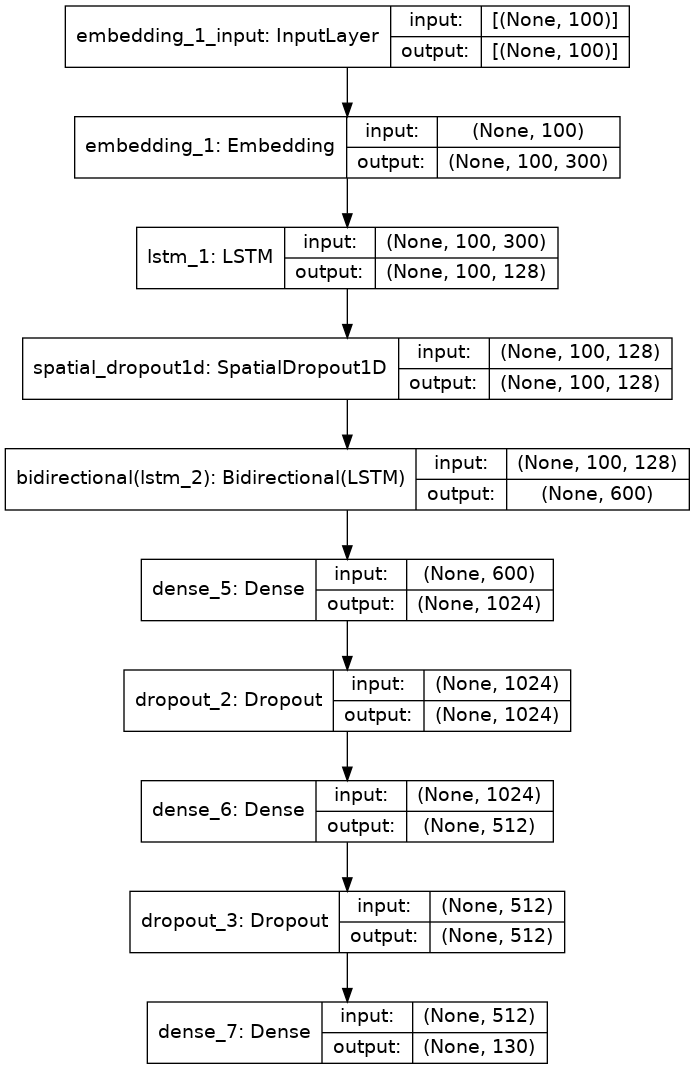

In [55]:
#plot
plot_model(GloVe_model, to_file = 'glove_model_plot.png', show_shapes = True, show_layer_names = True)

In [56]:
#compile
GloVe_model.compile(optimizer = keras.optimizers.Adam(0.0001), 
                    loss = 'categorical_crossentropy',
                    metrics = ['acc']) 

In [57]:
start = datetime.datetime.now()

#fit
GloVe_history = GloVe_model.fit(np.array(X_train_pad), np.array(y_train),
                                batch_size = 32,
                                epochs = 20,
                                verbose = 1,
                                validation_data = (np.array(X_test_pad), np.array(y_test)),
                                callbacks = early_stopping)

Epoch 1/20
492/492 [==============================] - 583s 1s/step - loss: 0.0807 - acc: 0.2118 - val_loss: 0.0121 - val_acc: 0.6901
Epoch 2/20
492/492 [==============================] - 571s 1s/step - loss: 0.0125 - acc: 0.6725 - val_loss: 0.0099 - val_acc: 0.6822
Epoch 3/20
492/492 [==============================] - 564s 1s/step - loss: 0.0103 - acc: 0.7025 - val_loss: 0.0095 - val_acc: 0.7343
Epoch 4/20
492/492 [==============================] - 569s 1s/step - loss: 0.0095 - acc: 0.7250 - val_loss: 0.0092 - val_acc: 0.7429
Epoch 5/20
492/492 [==============================] - 570s 1s/step - loss: 0.0092 - acc: 0.7282 - val_loss: 0.0090 - val_acc: 0.7442
Epoch 6/20
492/492 [==============================] - 574s 1s/step - loss: 0.0089 - acc: 0.7337 - val_loss: 0.0088 - val_acc: 0.7419
Epoch 7/20
492/492 [==============================] - 577s 1s/step - loss: 0.0088 - acc: 0.7218 - val_loss: 0.0086 - val_acc: 0.7399
Epoch 8/20
492/492 [==============================] - 567s 1s/step - 

In [58]:
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Training took a total of 3:09:24.678423


In [59]:
#save model
GloVe_model.save('glove_model.h5')

### Model Evaluation

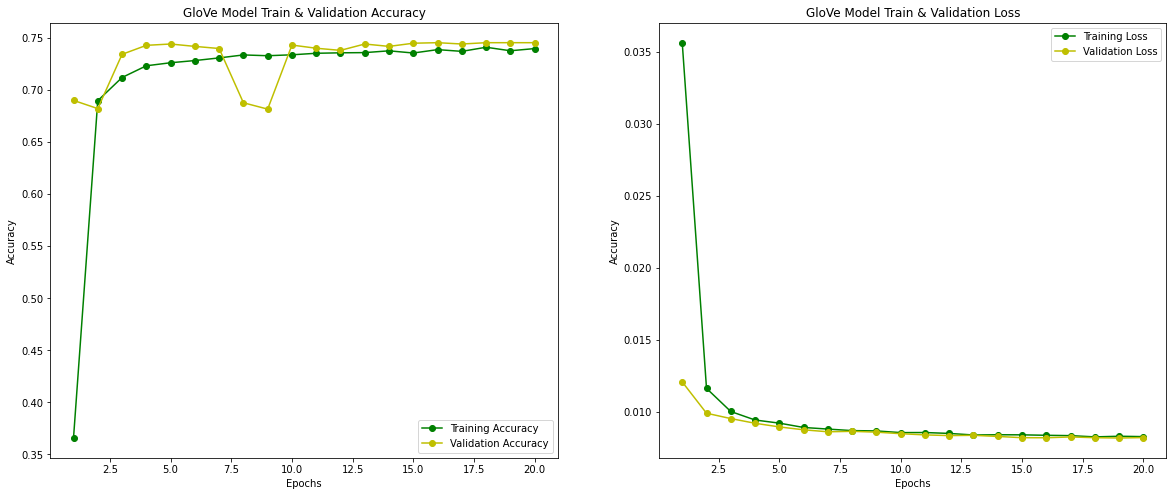

In [60]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 8)

GloVe_train_acc = GloVe_history.history['acc']
GloVe_train_loss = GloVe_history.history['loss']
GloVe_val_acc = GloVe_history.history['val_acc']
GloVe_val_loss = GloVe_history.history['val_loss']

epochs = range(1, len(GloVe_train_acc) + 1)

ax[0].plot(epochs , GloVe_train_acc , 'g-o' , label = 'Training Accuracy')
ax[0].plot(epochs , GloVe_val_acc , 'y-o' , label = 'Validation Accuracy')
ax[0].set_title('GloVe Model Train & Validation Accuracy')
ax[0].legend(loc = 'lower right')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, GloVe_train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs, GloVe_val_loss , 'y-o' , label = 'Validation Loss')
ax[1].set_title('GloVe Model Train & Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')

plt.show()

In [61]:
#save
plt.savefig('glove_acc_loss.png')

<Figure size 432x288 with 0 Axes>

In [62]:
print('Train loss & accuracy:', GloVe_model.evaluate(X_train_pad, y_train))
print('\n')
print('Test loss & accuracy:', GloVe_model.evaluate(X_test_pad, y_test))

492/492 [==============================] - 32s 65ms/step - loss: 0.0080 - acc: 0.7451
Train loss & accuracy: [0.008035912178456783, 0.7451042532920837]


123/123 [==============================] - 8s 64ms/step - loss: 0.0082 - acc: 0.7455
Test loss & accuracy: [0.008219493553042412, 0.7454869151115417]


In [63]:
#make prediction
GloVe_yhat_test = GloVe_model.predict(X_test_pad)

#to evaluate accuracy we need a vector of labels
GloVe_yhat_test = np.argmax(GloVe_yhat_test, axis = 1)
GloVe_y_test = np.argmax(y_test, axis = 1)

#get classification report
print('Model: GloVe', '\n', classification_report(GloVe_y_test, GloVe_yhat_test))

Model: GloVe 
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         2
           3       0.58      1.00      0.74       709
           4       0.00      0.00      0.00         2
           8       0.94      1.00      0.97       127
           9       0.00      0.00      0.00         8
          10       0.00      0.00      0.00       487
          11       0.00      0.00      0.00        17
          12       0.40      1.00      0.57         2
          13       0.00      0.00      0.00         1
          15       0.68      1.00      0.81        45
          16       0.00      0.00      0.00        21
          17       0.74      1.00      0.85       248
          18       0.00      0.00      0.00        86
          19       0.00      0.00      0.00        13
          20       0.47      1.00      0.64        47
          21       0.00      0.00      0.00        39
          25

In [64]:
#generate a prediction on individual examples
GloVe_text_labels = encoder.classes_ 

for i in range(10):
    prediction = GloVe_model.predict(np.array([X_test_pad[i]]))
    predicted_label = GloVe_text_labels[np.argmax(prediction)]
    print(train_df['dataset_title'].iloc[i][:50], '...')
    print('Actual label: ' + train_df['cleaned_label'].iloc[i])
    print('Predicted label: ' + predicted_label + '\n')

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: baltimore longitudinal study of aging

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: adni

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: noaa tide gauge

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: trends in international mathematics and science study

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: our world in data

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: adni

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: adni

National Education Longitudinal Study ...
Actual label: national education 

In [65]:
y_softmax = GloVe_model.predict(X_test_pad)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

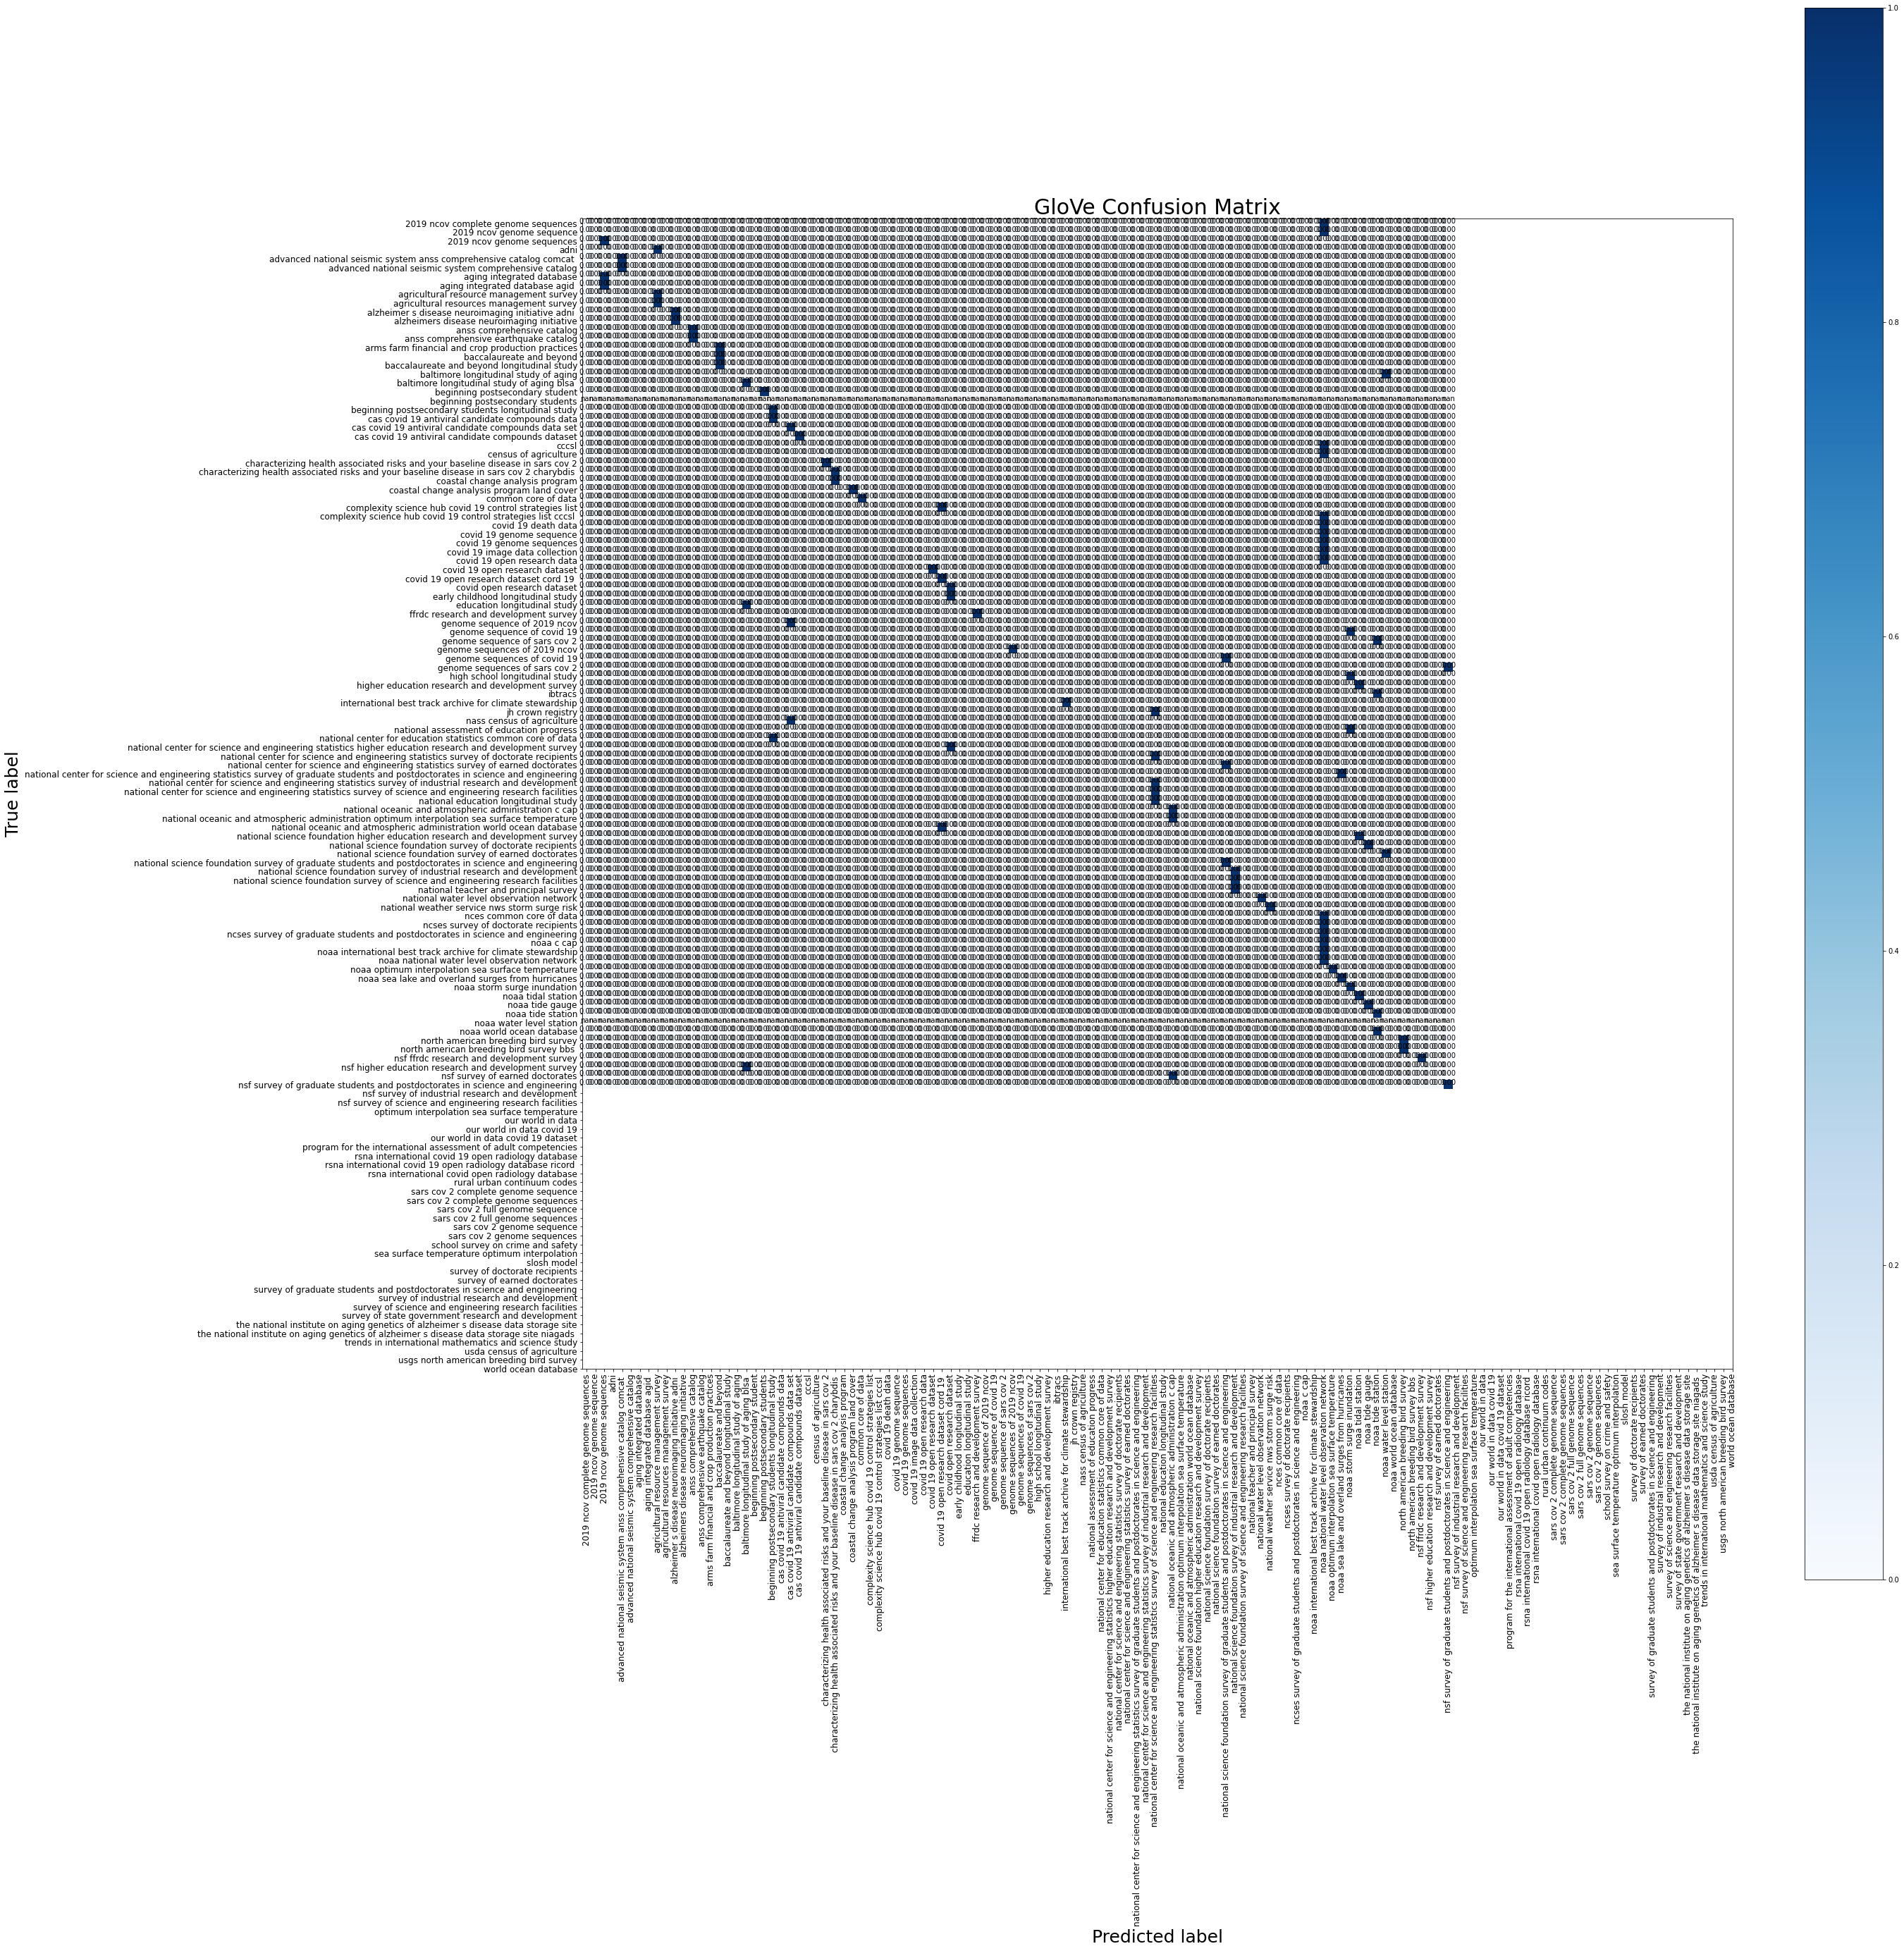

<Figure size 432x288 with 0 Axes>

In [66]:
#get confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize = (40, 40))
plot_confusion_matrix(cm, classes = GloVe_text_labels, title = 'GloVe Confusion Matrix')
plt.show()

#save
plt.savefig('glove_cm.png')

In [67]:
#update summary table
summary_table.loc[2] = ['DL GloVe',
                        round(accuracy_score(GloVe_y_test, GloVe_yhat_test), 2),
                        round(precision_score(GloVe_y_test, GloVe_yhat_test, average = 'macro'), 2), 
                        round(recall_score(GloVe_y_test, GloVe_yhat_test, average = 'macro'), 2), 
                        round(f1_score(GloVe_y_test, GloVe_yhat_test, average = 'macro'), 2)]
summary_table.head()

Model  Accuracy  Precision  Recall    F1
0    DL MLP      0.73       0.32    0.37  0.34
1   DL LSTM      0.74       0.31    0.37  0.33
2  DL GloVe      0.75       0.31    0.37  0.33

# GRU

In [68]:
GRU_model = Sequential()

#embedding layer
GRU_model.add(Embedding(size_of_vocabulary, 300,
                        weights = [embedding_matrix],
                        input_length = 100,
                        trainable = False)) 

#lstm layer
GRU_model.add(LSTM(128, return_sequences = True, dropout = 0.2))
GRU_model.add(SpatialDropout1D(0.3))
GRU_model.add(GRU(300, dropout = 0.3, recurrent_dropout = 0.3, return_sequences = True))
GRU_model.add(GRU(300, dropout = 0.3, recurrent_dropout = 0.3))

#fully connected layers
GRU_model.add(Dense(1024, activation = 'relu'))
GRU_model.add(Dropout(0.8))

GRU_model.add(Dense(512, activation = 'relu'))
GRU_model.add(Dropout(0.5))

#output layer
GRU_model.add(Dense(130, activation = 'sigmoid')) 

In [69]:
#summary
GRU_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 300)          46200     
_________________________________________________________________
lstm_3 (LSTM)                (None, 100, 128)          219648    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 100, 128)          0         
_________________________________________________________________
gru (GRU)                    (None, 100, 300)          387000    
_________________________________________________________________
gru_1 (GRU)                  (None, 300)               541800    
_________________________________________________________________
dense_8 (Dense)              (None, 1024)              308224    
_________________________________________________________________
dropout_4 (Dropout)          (None, 1024)             

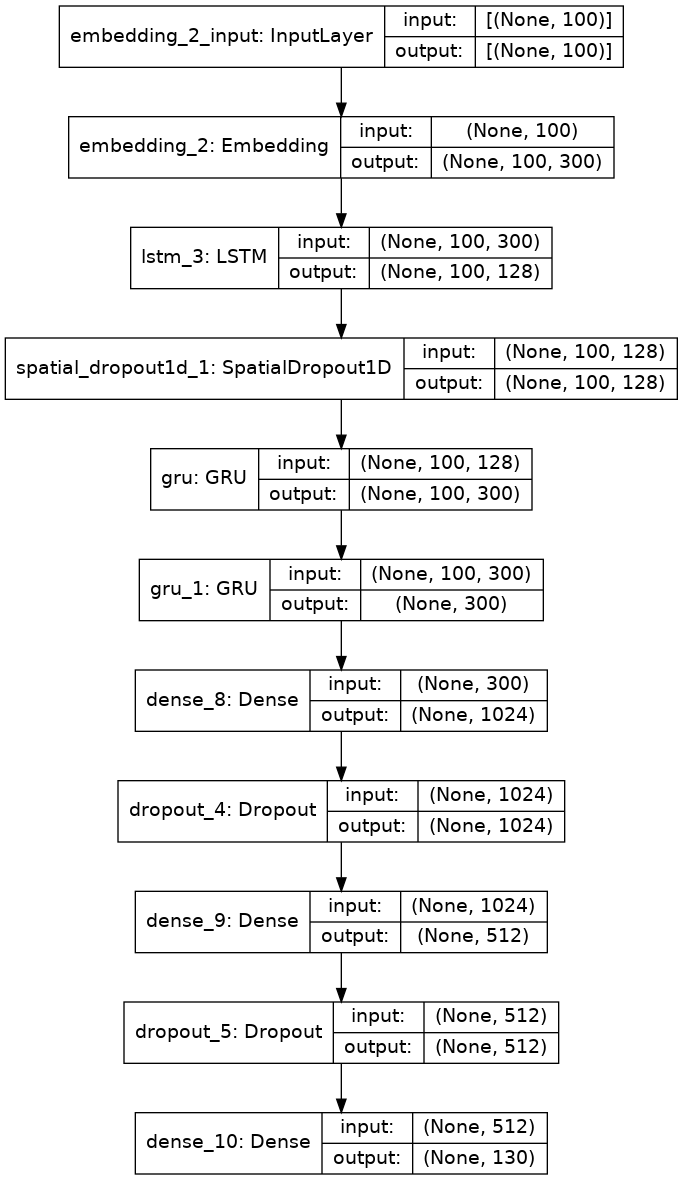

In [70]:
#plot
plot_model(GRU_model, to_file = 'GRU_model_plot.png', show_shapes = True, show_layer_names = True)

In [71]:
#compile
GRU_model.compile(optimizer = keras.optimizers.Adam(0.0001), 
                    loss = 'categorical_crossentropy',
                    metrics = ['acc']) 

In [72]:
start = datetime.datetime.now()

#fit
GRU_history = GRU_model.fit(np.array(X_train_pad), np.array(y_train),
                            batch_size = 32,
                            epochs = 20,
                            verbose = 1,
                            validation_data = (np.array(X_test_pad), np.array(y_test)),
                            callbacks = early_stopping)

Epoch 1/20
492/492 [==============================] - 539s 1s/step - loss: 0.0774 - acc: 0.2566 - val_loss: 0.0111 - val_acc: 0.7226
Epoch 2/20
492/492 [==============================] - 525s 1s/step - loss: 0.0124 - acc: 0.6684 - val_loss: 0.0101 - val_acc: 0.7366
Epoch 3/20
492/492 [==============================] - 521s 1s/step - loss: 0.0103 - acc: 0.7133 - val_loss: 0.0096 - val_acc: 0.7269
Epoch 4/20
492/492 [==============================] - 522s 1s/step - loss: 0.0098 - acc: 0.7185 - val_loss: 0.0092 - val_acc: 0.7401
Epoch 5/20
492/492 [==============================] - 519s 1s/step - loss: 0.0093 - acc: 0.7233 - val_loss: 0.0088 - val_acc: 0.7455
Epoch 6/20
492/492 [==============================] - 521s 1s/step - loss: 0.0092 - acc: 0.7298 - val_loss: 0.0091 - val_acc: 0.7307
Epoch 7/20
492/492 [==============================] - 514s 1s/step - loss: 0.0090 - acc: 0.7343 - val_loss: 0.0088 - val_acc: 0.7442
Epoch 8/20
492/492 [==============================] - 524s 1s/step - 

In [73]:
end = datetime.datetime.now()
elapsed = end - start
print('Training took a total of {}'.format(elapsed))

Training took a total of 2:55:54.657640


In [74]:
#save model
GRU_model.save('gru_model.h5')

### Model Evaluation

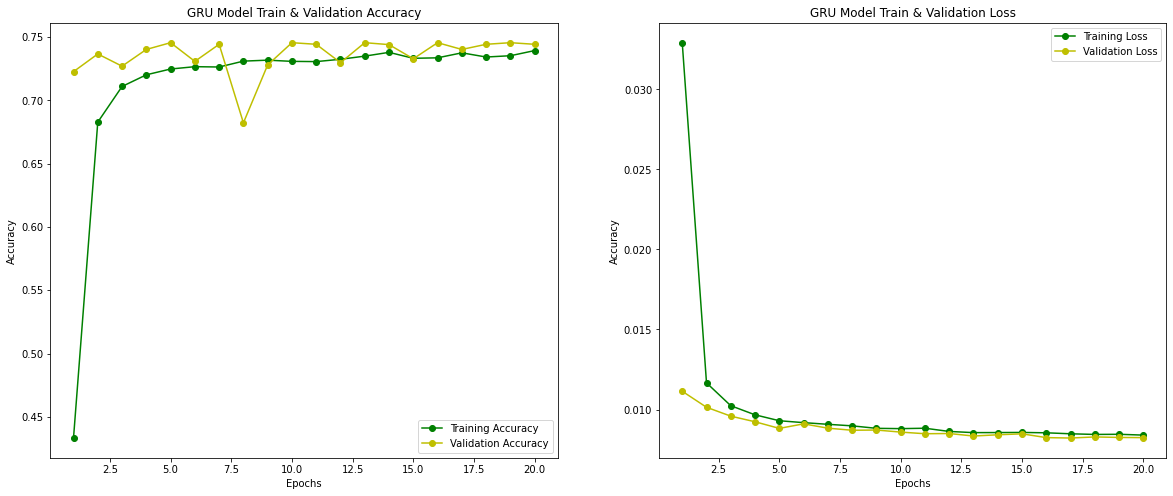

In [75]:
fig , ax = plt.subplots(1,2)
fig.set_size_inches(20, 8)

GRU_train_acc = GRU_history.history['acc']
GRU_train_loss = GRU_history.history['loss']
GRU_val_acc = GRU_history.history['val_acc']
GRU_val_loss = GRU_history.history['val_loss']

epochs = range(1, len(GRU_train_acc) + 1)

ax[0].plot(epochs , GRU_train_acc , 'g-o' , label = 'Training Accuracy')
ax[0].plot(epochs , GRU_val_acc , 'y-o' , label = 'Validation Accuracy')
ax[0].set_title('GRU Model Train & Validation Accuracy')
ax[0].legend(loc = 'lower right')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Accuracy')

ax[1].plot(epochs, GRU_train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs, GRU_val_loss , 'y-o' , label = 'Validation Loss')
ax[1].set_title('GRU Model Train & Validation Loss')
ax[1].legend()
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy')

plt.show()

In [76]:
#save
plt.savefig('gru_acc_loss.png')

<Figure size 432x288 with 0 Axes>

In [77]:
print('Train loss & accuracy:', GRU_model.evaluate(X_train_pad, y_train))
print('\n')
print('Test loss & accuracy:', GRU_model.evaluate(X_test_pad, y_test))

492/492 [==============================] - 37s 76ms/step - loss: 0.0081 - acc: 0.7440
Train loss & accuracy: [0.008146839216351509, 0.7440233826637268]


123/123 [==============================] - 9s 72ms/step - loss: 0.0082 - acc: 0.7442
Test loss & accuracy: [0.008242764510214329, 0.7442156076431274]


In [78]:
#make prediction
GRU_yhat_test = GRU_model.predict(X_test_pad)

#to evaluate accuracy we need a vector of labels
GRU_yhat_test = np.argmax(GRU_yhat_test, axis = 1)
GRU_y_test = np.argmax(y_test, axis = 1)

#get classification report
print('Model: GRU', '\n', classification_report(GRU_y_test, GRU_yhat_test))

Model: GRU 
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         2
           3       0.58      1.00      0.74       709
           4       0.00      0.00      0.00         2
           8       0.94      1.00      0.97       127
           9       0.00      0.00      0.00         8
          10       0.00      0.00      0.00       487
          11       0.00      0.00      0.00        17
          12       0.40      1.00      0.57         2
          13       0.00      0.00      0.00         1
          15       0.68      1.00      0.81        45
          16       0.00      0.00      0.00        21
          17       0.74      1.00      0.85       248
          18       0.00      0.00      0.00        86
          19       0.00      0.00      0.00        13
          20       0.47      1.00      0.64        47
          21       0.00      0.00      0.00        39
          25  

In [79]:
#generate a prediction on individual examples
GRU_text_labels = encoder.classes_ 

for i in range(10):
    prediction = GRU_model.predict(np.array([X_test_pad[i]]))
    predicted_label = GRU_text_labels[np.argmax(prediction)]
    print(train_df['dataset_title'].iloc[i][:50], '...')
    print('Actual label: ' + train_df['cleaned_label'].iloc[i])
    print('Predicted label: ' + predicted_label + '\n')

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: baltimore longitudinal study of aging

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: adni

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: noaa tide gauge

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: trends in international mathematics and science study

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: our world in data

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: adni

National Education Longitudinal Study ...
Actual label: national education longitudinal study
Predicted label: adni

National Education Longitudinal Study ...
Actual label: national education 

In [80]:
y_softmax = GRU_model.predict(X_test_pad)

y_test_1d = []
y_pred_1d = []

for i in range(len(y_test)):
    probs = y_test[i]
    index_arr = np.nonzero(probs)
    one_hot_index = index_arr[0].item(0)
    y_test_1d.append(one_hot_index)

for i in range(0, len(y_softmax)):
    probs = y_softmax[i]
    predicted_index = np.argmax(probs)
    y_pred_1d.append(predicted_index)

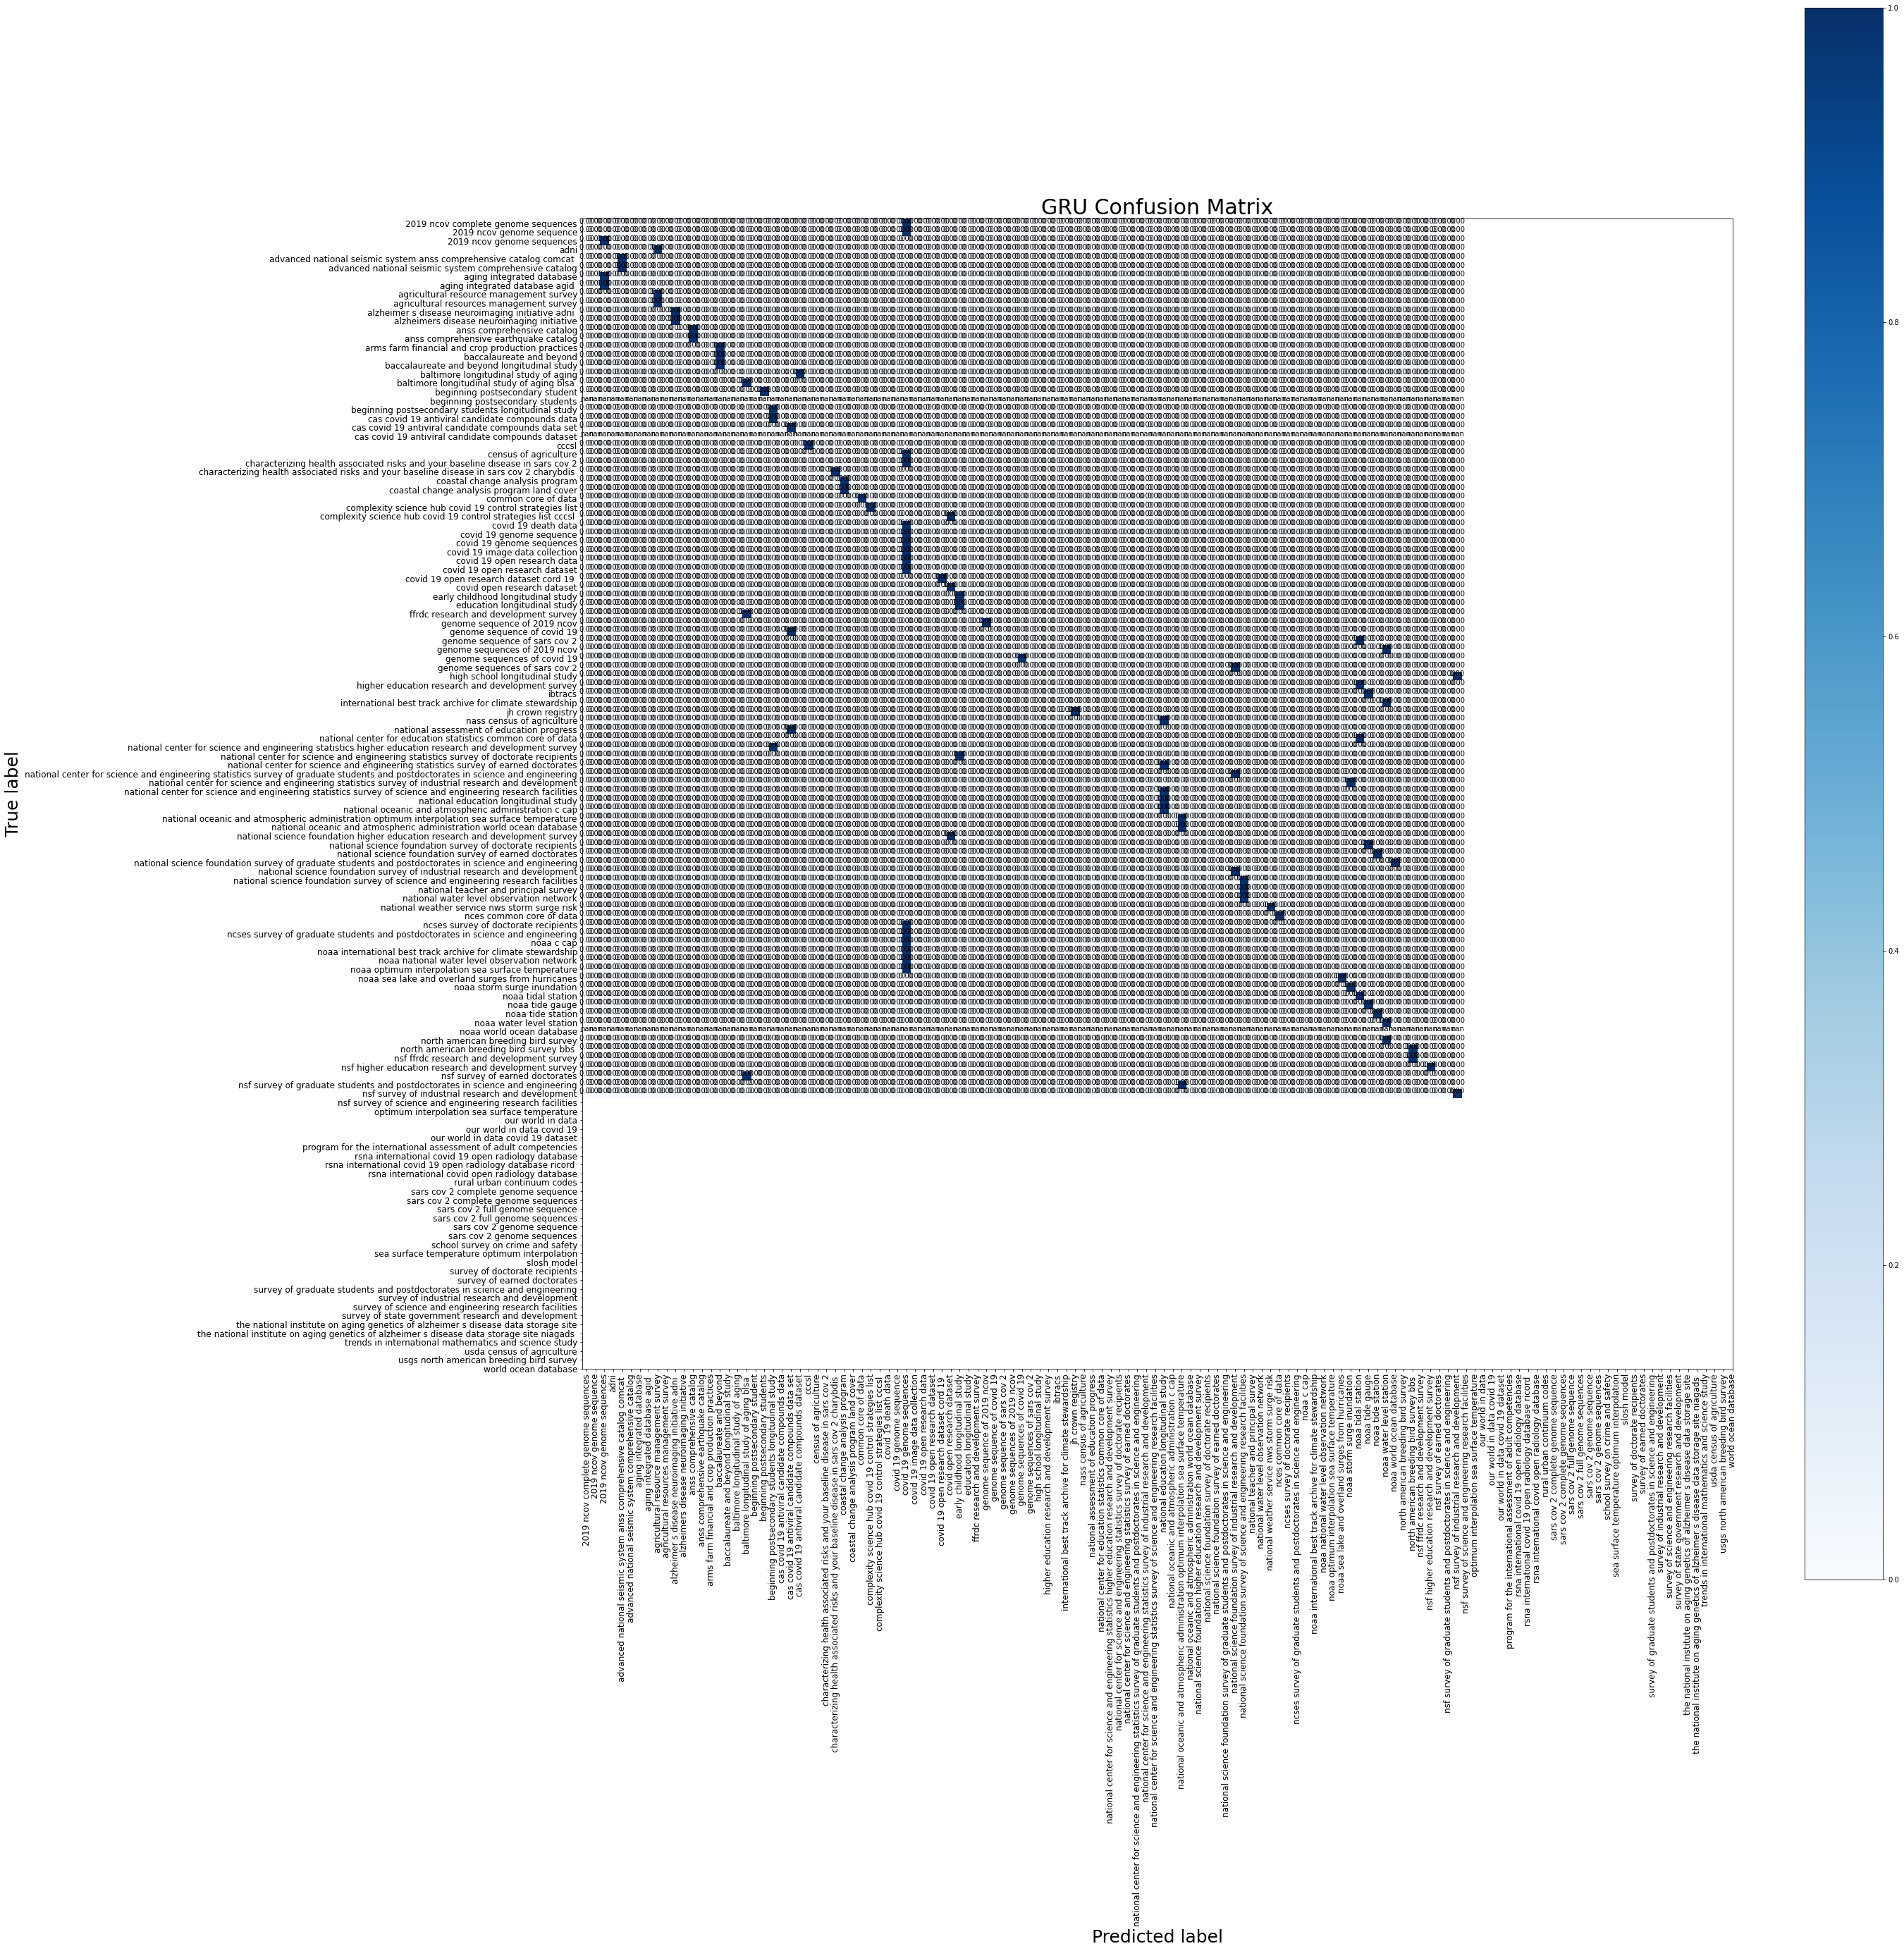

<Figure size 432x288 with 0 Axes>

In [81]:
#get confusion matrix
cm = confusion_matrix(y_test_1d, y_pred_1d)
plt.figure(figsize = (40, 40))
plot_confusion_matrix(cm, classes = GRU_text_labels, title = 'GRU Confusion Matrix')
plt.show()

#save
plt.savefig('gru_cm.png')

In [82]:
#update summary table
summary_table.loc[3] = ['DL GRU',
                        round(accuracy_score(GRU_y_test, GRU_yhat_test), 2),
                        round(precision_score(GRU_y_test, GRU_yhat_test, average = 'macro'), 2), 
                        round(recall_score(GRU_y_test, GRU_yhat_test, average = 'macro'), 2), 
                        round(f1_score(GRU_y_test, GRU_yhat_test, average = 'macro'), 2)]
summary_table.head()

Model  Accuracy  Precision  Recall    F1
0    DL MLP      0.73       0.32    0.37  0.34
1   DL LSTM      0.74       0.31    0.37  0.33
2  DL GloVe      0.75       0.31    0.37  0.33
3    DL GRU      0.74       0.30    0.36  0.32

# INTERPRETATION

In [83]:
#https://www.kaggle.com/lalomb40/nlp-just-learning#3.-Data-Exploration-and-Manipulation

def clean_text(txt):
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower()).strip()

temp_0 = [x.lower() for x in train_df['dataset_title'].unique()]
temp_1 = [x.lower() for x in train_df['cleaned_label'].unique()]
temp_2 =  [x.lower() for x in train_df['Id'].unique()]
existing_labels = set(temp_0 + temp_1 + temp_2)
labels = existing_labels
id_list = []
lables_list = []
gt =[]
for index, row in tqdm(submission_df.iterrows()):
    sample_text = row['text']
    row_id = row['Id']
    temp_df = train_df[train_df['text'] == clean_text(sample_text)]
    cleaned_labels = temp_df['cleaned_label'].to_list()
    gt.append(cleaned_labels)
    for known_label in existing_labels:
        if known_label in sample_text.lower():
            cleaned_labels.append(clean_text(known_label))
    cleaned_labels = [clean_text(x) for x in cleaned_labels]
    cleaned_labels = set(cleaned_labels)
    lables_list.append(' | '.join(cleaned_labels))
    id_list.append(row_id)

0it [00:00, ?it/s]

In [84]:
submission = pd.DataFrame()
submission['Id'] = id_list
submission['prediction_string'] = lables_list
submission['ground_truth'] = gt

In [85]:
#check results sample
filt = train_df['Id'].str.contains('3f316b38-1a24-45a9-8d8c-4e05a42257c6', na = False)
train_df.loc[filt, 'cleaned_label'].to_frame()

cleaned_label
14188                  slosh model
14189  noaa storm surge inundation